In [3]:
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization
from keras.optimizers import Adam, Nadam, Adamax, RMSprop
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


## model setup and training

In [ ]:
# define metrics and structure of unet model

In [33]:
img_rows = 32
img_cols = 32

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacc_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jacc_coef_loss(y_true, y_pred):
    return -jacc_coef(y_true, y_pred)

def jacc_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def get_unet():
    inputs = Input((img_rows, img_cols, 42))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization(axis = 1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    
    # best model
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, jacc_coef_int])
    
    # other options
    # model.compile(optimizer=RMSprop(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef, jacc_coef_int])
    # model.compile(optimizer=Nadam(lr = 1e-4), loss=dice_coef_loss, metrics=[dice_coef, jacc_coef_int])
    # model.compile(optimizer=Adam(lr = 1e-4), loss=dice_coef_loss, metrics=[dice_coef, jacc_coef_int])
    # model.compile(optimizer=Adam(lr=lr), loss=jacc_coef_loss, metrics=[jacc_coef_int])
    # model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=[jacc_coef_int])
    # model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=[dice_coef, jacc_coef_int])

    return model

In [8]:
train_images_nonzero = [os.path.join('train/imgs/nonzero', image_name) 
               for image_name in os.listdir('train/imgs/nonzero')]
train_masks_nonzero = [os.path.join('train/masks/nonzero', image_name) 
               for image_name in os.listdir('train/masks/nonzero')]
train_images_zero = [os.path.join('train/imgs/zero', image_name) 
               for image_name in os.listdir('train/imgs/zero')]
train_masks_zero = [os.path.join('train/masks/zero', image_name) 
               for image_name in os.listdir('train/masks/zero')]


validation_images_nonzero = [os.path.join('validation/imgs/nonzero', image_name) 
               for image_name in os.listdir('validation/imgs/nonzero')]
validation_masks_nonzero = [os.path.join('validation/masks/nonzero', image_name) 
               for image_name in os.listdir('validation/masks/nonzero')]
validation_images_zero = [os.path.join('validation/imgs/zero', image_name) 
               for image_name in os.listdir('validation/imgs/zero')]
validation_masks_zero = [os.path.join('validation/masks/zero', image_name) 
               for image_name in os.listdir('validation/masks/zero')]



holdout_images_nonzero = [os.path.join('holdout/imgs/nonzero', image_name) 
               for image_name in os.listdir('holdout/imgs/nonzero')]
holdout_masks_nonzero = [os.path.join('holdout/masks/nonzero', image_name) 
               for image_name in os.listdir('holdout/masks/nonzero')]
holdout_images_zero = [os.path.join('holdout/imgs/zero', image_name) 
               for image_name in os.listdir('holdout/imgs/zero')]
holdout_masks_zero = [os.path.join('holdout/masks/zero', image_name) 
               for image_name in os.listdir('holdout/masks/zero')]


def balanced_generator(img_files_nonzero, img_files_zero, truth_files_nonzero, truth_files_zero, batch_size):
    # Create empty arrays to contain batch of features and labels
    batch_images = np.zeros((batch_size, 32, 32, 42))
    batch_truth = np.zeros((batch_size, 32, 32, 1))
    while True:
        for i in range(int(batch_size/2)):
            # choose random index in features for nonzero
            index = int(np.random.choice(len(img_files_nonzero),1))
            batch_images[i] = np.load(img_files_nonzero[index])
            batch_truth[i] = np.expand_dims(np.load(truth_files_nonzero[index]), axis=2)
        for i in range(int(batch_size/2), batch_size):
            # choose random index in features for zero
            index = int(np.random.choice(len(img_files_zero),1))
            batch_images[i] = np.load(img_files_zero[index])
            batch_truth[i] = np.expand_dims(np.load(truth_files_zero[index]), axis=2)
        yield (batch_images, batch_truth)

In [971]:
# next(balanced_generator(train_images_nonzero, train_images_zero, train_masks_nonzero,\
#                                                  train_masks_zero, 1))[0].shape

In [973]:
model = get_unet()

In [974]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_25 (InputLayer)            (None, 32, 32, 42)    0                                            
____________________________________________________________________________________________________
conv2d_435 (Conv2D)              (None, 32, 32, 32)    12128       input_25[0][0]                   
____________________________________________________________________________________________________
dropout_207 (Dropout)            (None, 32, 32, 32)    0           conv2d_435[0][0]                 
____________________________________________________________________________________________________
conv2d_436 (Conv2D)              (None, 32, 32, 32)    9248        dropout_207[0][0]                
___________________________________________________________________________________________

In [976]:
nb_epoch = 40
batch_size = 32
nb_train_samples = len(train_images_nonzero) + len(train_images_zero)
nb_validation_samples = len(validation_images_nonzero) + len(validation_images_zero)

In [977]:
model_checkpoint = ModelCheckpoint(os.path.join('/mnt/checkpoints', 'weights.h5'), \
                                                monitor='val_loss', save_best_only=True)

In [978]:
history = model.fit_generator(balanced_generator(train_images_nonzero, train_images_zero, train_masks_nonzero,\
                                                 train_masks_zero, batch_size),
                    steps_per_epoch=(nb_train_samples // batch_size),
                    epochs=nb_epoch, 
                    validation_data=balanced_generator(validation_images_nonzero, validation_images_zero,\
                                                       validation_masks_nonzero, validation_masks_zero, batch_size),
                    validation_steps=(nb_validation_samples // batch_size), 
                    callbacks = [model_checkpoint])

Epoch 1/40
26/26 [==============================] - 19s - loss: -0.2115 - dice_coef: 0.2115 - jacc_coef_int: 0.1429 - val_loss: -0.2117 - val_dice_coef: 0.2117 - val_jacc_coef_int: 0.2355
Epoch 2/40
26/26 [==============================] - 11s - loss: -0.2090 - dice_coef: 0.2090 - jacc_coef_int: 0.1503 - val_loss: -0.2203 - val_dice_coef: 0.2203 - val_jacc_coef_int: 0.2600
Epoch 3/40
26/26 [==============================] - 11s - loss: -0.2094 - dice_coef: 0.2094 - jacc_coef_int: 0.1515 - val_loss: -0.2226 - val_dice_coef: 0.2226 - val_jacc_coef_int: 0.2609
Epoch 4/40
26/26 [==============================] - 11s - loss: -0.2349 - dice_coef: 0.2349 - jacc_coef_int: 0.1705 - val_loss: -0.2286 - val_dice_coef: 0.2286 - val_jacc_coef_int: 0.2599
Epoch 5/40
26/26 [==============================] - 11s - loss: -0.2474 - dice_coef: 0.2474 - jacc_coef_int: 0.1769 - val_loss: -0.2166 - val_dice_coef: 0.2166 - val_jacc_coef_int: 0.2333
Epoch 6/40
26/26 [==============================] - 11s - lo

In [ ]:
history.history.keys()

In [981]:
val_dice = history.history['val_dice_coef']
val_loss = history.history['val_loss']

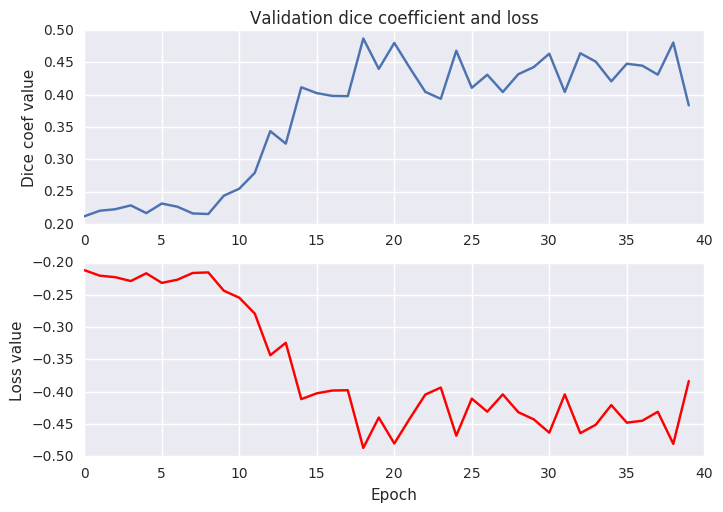

In [982]:
fig = plt.figure(1)

# plot dice
plt.subplot(211)
plt.plot(val_dice)
plt.title('Validation dice coefficient and loss')
plt.ylabel('Dice coef value')

# plot loss
plt.subplot(212)
plt.plot(val_loss, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss value')

plt.show()

In [25]:
## to load previous model:
# model = get_unet()
# model.load_weights('model_weights_627_pm.h5')
# # comment out compiler line and re-run unet model code, then:
# model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, jacc_coef_int])

## generate predictions and explore model results

In [28]:
def threshold_wrapper(proba_list, threshold):
    """Helper function to enable different thresholds to be set"""
    output_list = []
    for proba in proba_list:
        if proba >= threshold:
            output_list.append(1)
        else:
            output_list.append(0)
    return output_list

In [29]:
def get_predictions(image_list, threshold):

    y_true = []
    y_pred = []
    y_proba = []
    
    for i in range(len(image_list[0])):
            
            ground_truth = np.load(image_list[1][i])
            y_true.extend(ground_truth.flatten())
            
            prediction = model.predict(np.expand_dims(np.load(image_list[0][i]), axis = 0))
            
            proba = (np.squeeze(prediction)).flatten()
            y_proba.extend(proba)
            
            pred = threshold_wrapper((np.squeeze(prediction)).flatten(), threshold)
            y_pred.extend(pred)
            
    return y_true, y_pred, y_proba

In [ ]:
# generate predictions for validation set, print classification report and plot ROC

In [30]:
validation_images = validation_images_nonzero + validation_images_zero
validation_masks = validation_masks_nonzero + validation_masks_zero

validation_list = [validation_images, validation_masks]

In [32]:
y_true, y_pred, y_proba = get_predictions(validation_list, .5)
print(classification_report(y_true, y_pred))
print(adjusted_mutual_info_score(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.96      0.76      0.85    318229
          1       0.37      0.81      0.51     53483

avg / total       0.87      0.77      0.80    371712

0.141625282562


In [988]:
# y_true, y_pred, y_proba = get_predictions(validation_list, .05)
# print(classification_report(y_true, y_pred))

In [989]:
# y_true, y_pred, y_proba = get_predictions(validation_list, .01)
# print(classification_report(y_true, y_pred))

In [55]:
sns.set_style("whitegrid", {'axes.grid' : False})

Model: U-Net Classifier
AUC: 0.846399805541



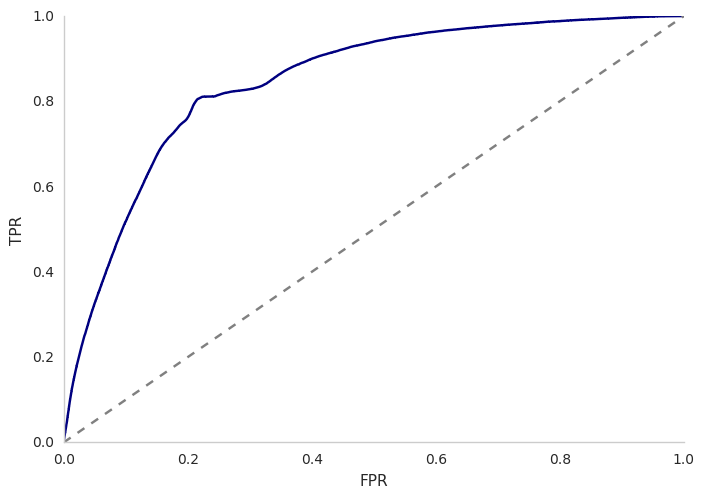

In [60]:
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

print('Model: U-Net Classifier')
print('AUC: ' + str(roc_auc))
print("")

plt.plot(fpr, tpr, color = 'navy')
plt.plot([0,1],[0,1], '--', color = 'grey')
plt.xlabel('FPR')
plt.ylabel('TPR')
# plt.title('U-Net ROC: Validation');
sns.despine()

In [ ]:
# do the same for holdout set

In [62]:
holdout_images = holdout_images_nonzero + holdout_images_zero
holdout_masks = holdout_masks_nonzero + holdout_masks_zero

In [63]:
holdout_list = [holdout_images, holdout_masks]

In [64]:
y_true, y_pred, y_proba = get_predictions(holdout_list, .8)
print(classification_report(y_true, y_pred))
print(adjusted_mutual_info_score(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.38      0.55    122416
          1       0.14      0.98      0.25     12752

avg / total       0.91      0.43      0.52    135168

0.0512042036608


Model: U-Net Classifier
AUC: 0.814290929241



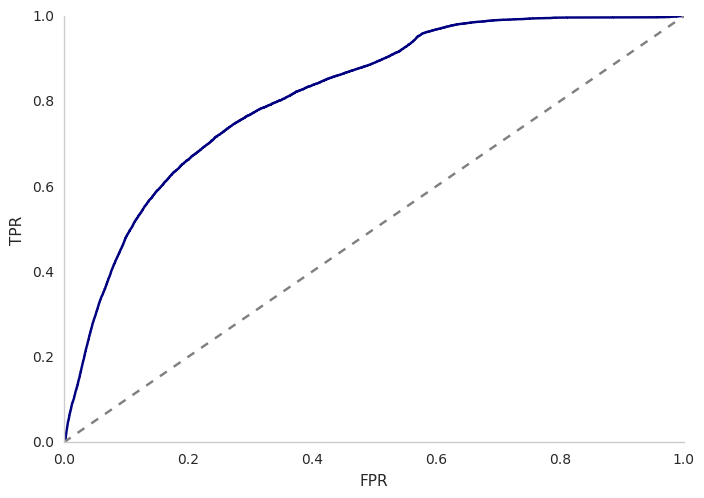

In [65]:
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

print('Model: U-Net Classifier')
print('AUC: ' + str(roc_auc))
print("")

plt.plot(fpr, tpr, color = 'navy')
plt.plot([0,1],[0,1], '--', color = 'grey')
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.title('U-Net ROC: Holdout');
sns.despine()

In [ ]:
# explore different thresholds (choose ideal based on precision/recall tradeoff)

In [995]:
y_true, y_pred, y_proba = get_predictions(holdout_list, .95)
print(classification_report(y_true, y_pred))
print(adjusted_mutual_info_score(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.96      0.75      0.84    122416
          1       0.23      0.73      0.35     12752

avg / total       0.89      0.74      0.79    135168

0.0669379942846


In [1041]:
y_true, y_pred, y_proba = get_predictions(holdout_list, .96)
print(classification_report(y_true, y_pred))
print(adjusted_mutual_info_score(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.85      0.90    122416
          1       0.29      0.60      0.39     12752

avg / total       0.89      0.82      0.85    135168

0.0839100617308


In [1035]:
y_true, y_pred, y_proba = get_predictions(holdout_list, .97)
print(classification_report(y_true, y_pred))
print(adjusted_mutual_info_score(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.93      0.93    122416
          1       0.36      0.38      0.37     12752

avg / total       0.88      0.88      0.88    135168

0.09391849394


## look at individual 32 x 32 squares: ground truth and prediction

In [996]:
def threshold_matrix_wrap(prediction, threshold):
    output_list = []
    for proba in np.squeeze(prediction).flatten():
        if proba >= threshold:
            output_list.append(1)
        else:
            output_list.append(0)
    return np.reshape(output_list, (32, 32))

In [21]:
#X, y = next(balanced_generator(train_images_nonzero, train_images_zero, train_masks_nonzero, train_masks_zero, 2))
X, y = next(balanced_generator(holdout_images_nonzero, holdout_images_zero, holdout_masks_nonzero, holdout_masks_zero, 2))

In [22]:
nonzero_y = np.squeeze(y[0])
zero_y = np.squeeze(y[1])

In [ ]:
prediction = model.predict(X)

In [ ]:
plt.imshow(nonzero_y)

In [ ]:
plt.imshow(threshold_matrix_wrap(prediction[0], .95))

## reconstruct original image and compare ground truth and prediction

In [ ]:
def array_to_list(pred_array):
    pred_list = []
    for i in range(pred_array.shape[0]):
        arr = np.squeeze(pred_array[i, :, :, :])
        pred_list.append(arr)
    return pred_list

In [1003]:
def reconstruct(mask_list):
            
    rows = []
    for i in range(0, len(mask_list), 12):
        rows.append(np.concatenate(mask_list[i:i+12], axis = 1))

    reconstructed = np.concatenate(rows, axis = 0)
    
    return reconstructed

In [1098]:
holdout_masks = np.load('holdout_masks.npy')
holdout_imgs = np.load('holdout_imgs.npy')

y_pred = model.predict(holdout_imgs)

matrices_post_th = []
for matrix in array_to_list(y_pred):
    matrices_post_th.append(threshold_matrix_wrap(matrix, .96))

# create density map
holdout_reconstructed = reconstruct(matrices_post_th)

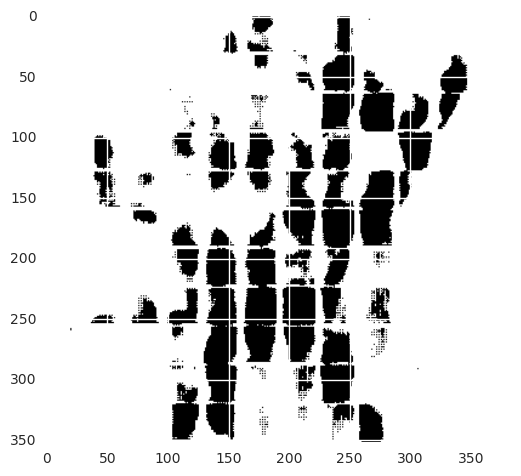

In [1099]:
# based on model predictions (black indicates damaged areas)
plt.imshow(holdout_reconstructed)

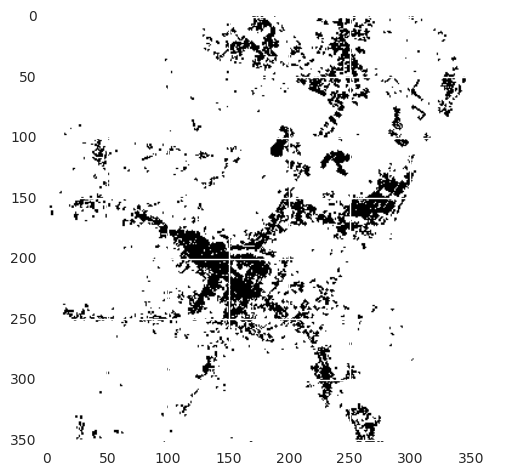

In [969]:
# ground truth (black represents damaged areas)
plt.imshow(reconstruct(holdout_masks))

## create density map

In [1100]:
x = np.nonzero(holdout_reconstructed)[1]
y = np.nonzero(holdout_reconstructed)[0]

In [1101]:
pix_coords = np.vstack((x, y)).T
pix_coords.shape

(26567, 2)

In [1102]:
pix_coords

array([[170,   1],
       [171,   1],
       [172,   1],
       ..., 
       [273, 351],
       [274, 351],
       [275, 351]])

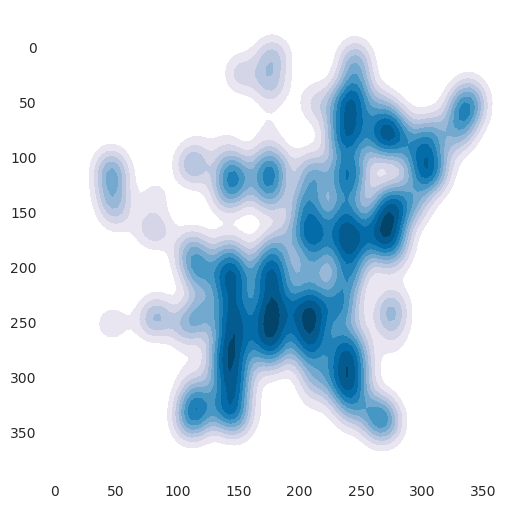

In [1107]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.kdeplot(pix_coords, shade = True, cmap = "PuBu")
ax.invert_yaxis()
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
plt.show()

In [ ]:
# model.save_weights('model_weights_627_pm.h5')
# model.save('model_627_pm.h5')